In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [2]:
loan = pd.read_csv(r"Task 3 and 4_Loan_Data.csv")
#loan.set_index('customer_id', inplace=True) 

In [3]:
loan

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [4]:
# missing values
loan.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

No missing value, do not need to handle missing value for pipeline

1. Default is catergorical variable
2. The rests are numerical variables

In [5]:
# get the count of defaulters and non defaulters
print(loan['default'].value_counts())

# get the ratio of defaulters and non defaulters
print(loan['default'].value_counts(normalize=True))

default
0    8149
1    1851
Name: count, dtype: int64
default
0    0.8149
1    0.1851
Name: proportion, dtype: float64


By the initial data exploration, the dataset has uneven label for the target variable of "dafault"

In [6]:
x = loan.drop(columns=['customer_id','default'])
y = loan.default

- credit_lines_outstanding:    Discrete
- loan_amt_outstanding:        continous
- total_debt_outstanding:      continous
- income:                      continous
- years_employed:              Discrete
- fico_score:                  continous
- default:                     categorical/binary

In [7]:
from sklearn.model_selection import train_test_split
rng = np.random.RandomState(0) # this helps us control the randomness so we can reproduce results exactly
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=rng)

For loan default prediction, both Random Forest and Gradient Boosting Classifiers are strong contenders due to their ability to 
- handle imbalanced data, robustness to outliers, and effectiveness in capturing complex, non-linear relationships.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.ensemble import RandomForestClassifier
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=rng)    # pick and set up fold method

# need to set up classifier rather than regressor
random_forest = RandomForestClassifier(random_state=rng)            # set up model/estimator

### Build a pipeline

In [9]:
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn import set_config          
set_config(transform_output="pandas") 

random_forest_pipe = make_pipeline(SimpleImputer(strategy='mean'),random_forest)
random_forest_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=RandomState(MT19937) at 0x177DE6B40))])

In [13]:
random_forest_pipe.fit(X_train,y_train)
random_forest_pipe.predict(X_test)
scores = cross_validate(random_forest, X_train, y_train, cv=cv, scoring="accuracy")
print(scores["test_score"].mean())  # scores is just a dictionary
print(scores["test_score"].std())

0.9949333333333333
0.0017688665548562124


In [14]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

#############
# Step 1: how to deal with numerical vars
# pro-tip: you might set up several numeric pipelines, because
# some variables might need very different treatment!
#############

numer_pipe = make_pipeline(SimpleImputer(strategy='mean')) 
# this deals with missing values (somehow?)
# you might also standardize the vars in this numer_pipe

#############
# Step 2: how to deal with categorical vars
#############

cat_pipe = make_pipeline(OrdinalEncoder())

# notes on this cat pipe:
#     OneHotEncoder is just one way to deal with categorical vars
#     drop='first' is necessary if the model is regression
#     sparse_output=False might slow down sklearn, BUT IT MUST BE USED WITH set_config(pandas) !!! 

#############
# Step 3: combine the subparts
#############

categorical_columns = ['credit_lines_outstanding', 'years_employed'] 

preproc_pipe = ColumnTransformer(
    [
        ("num_impute", numer_pipe, ['loan_amt_outstanding', 'total_debt_outstanding', 
                                    'income', 'fico_score']),
        ("cat_trans", cat_pipe, categorical_columns)
    ], 
    remainder='drop'
)

#############
# Step 4: put the preprocessing into an estimation pipeline
#############

new_random_forest_pipe = make_pipeline(preproc_pipe,random_forest)
new_random_forest_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_impute',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['loan_amt_outstanding',
                                                   'total_debt_outstanding',
                                                   'income', 'fico_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['credit_lines_outstanding',
                                                   'years_employed'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=RandomState(MT19937) at 0x177DE6B40))])

In [15]:
new_random_forest_pipe.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,new_random_forest_pipe.predict(X_test,))

0.992

In [16]:
new_random_forest_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num_impute',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer())]),
                                    ['loan_amt_outstanding',
                                     'total_debt_outstanding', 'income',
                                     'fico_score']),
                                   ('cat_trans',
                                    Pipeline(steps=[('ordinalencoder',
                                                     OrdinalEncoder())]),
                                    ['credit_lines_outstanding',
                                     'years_employed'])])),
  ('randomforestclassifier',
   RandomForestClassifier(random_state=RandomState(MT19937) at 0x177DE6B40))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num_impute',
                                  Pipeline(steps=[('sim

### GridSearchCV

In [17]:
from sklearn.model_selection import GridSearchCV

# 1. Set up your parameter grids (all of the parameters you would like to test). 

param_grid = {
    # Parameters for RandomForestClassifier
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],

    # If you want to include parameters for preprocessing steps, you can do so here
    # For example, if you want to experiment with different imputation strategies
    # 'columntransformer__num_impute__simpleimputer__strategy': ['mean', 'median']
}

# 2. Set up GridSearchCV
grid_search = GridSearchCV(new_random_forest_pipe, param_grid, cv=5, scoring='accuracy', verbose=1)

# Replace 'your_pipeline' with the variable name of your actual pipeline


In [18]:
# 3. Get the search results by fitting GridSearchCV

results = grid_search.fit(X_train,y_train)
                           
# 4. Save the best parameters

results_df = pd.DataFrame(results.cv_results_).set_index('params')


Fitting 5 folds for each of 36 candidates, totalling 180 fits


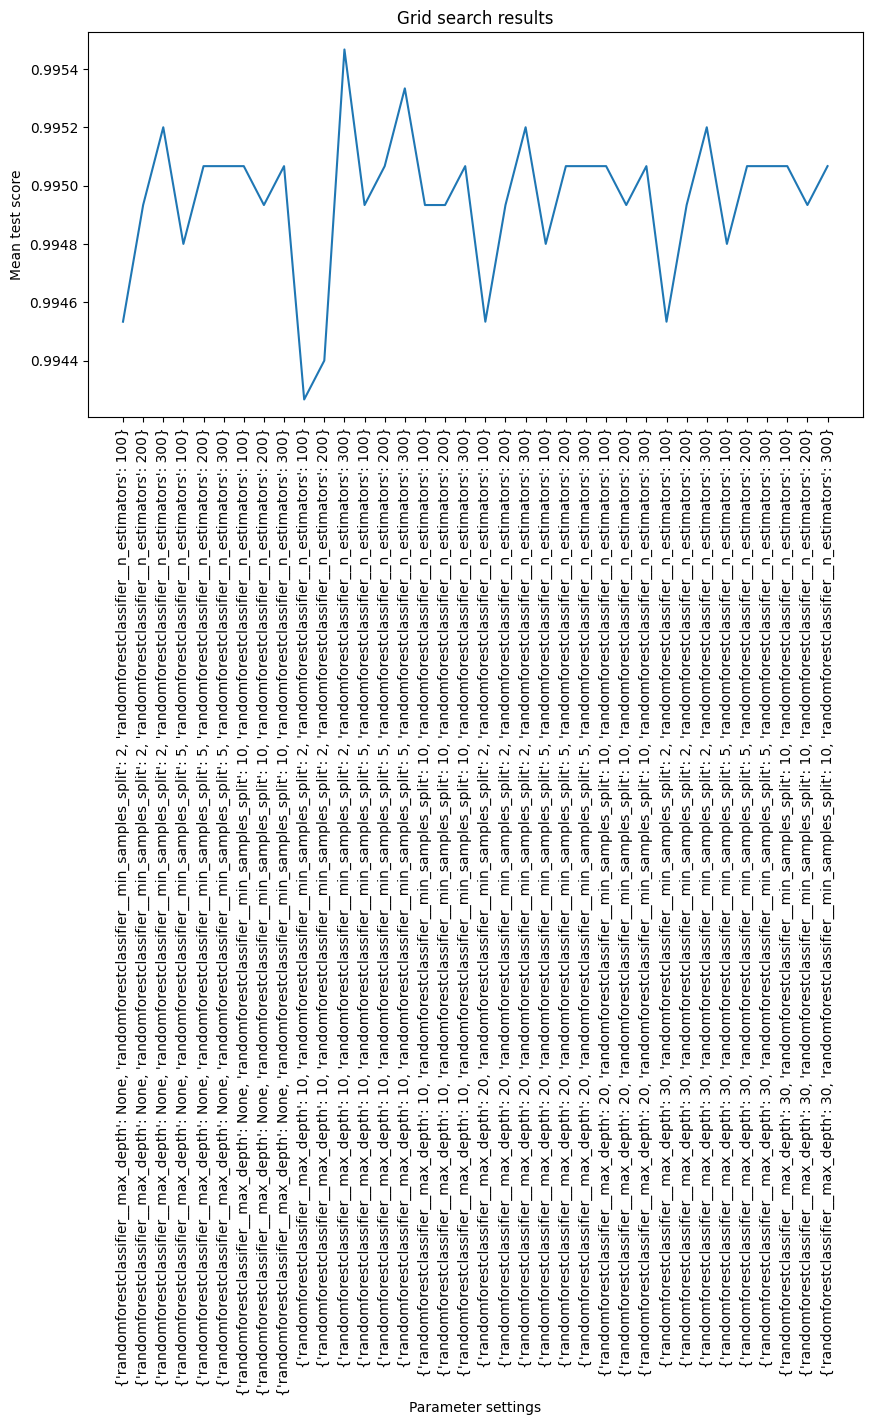

In [21]:
# plot the results
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(results_df)), results_df['mean_test_score'])
ax.set_xlabel('Parameter settings')
ax.set_ylabel('Mean test score')
ax.set_title('Grid search results')
ax.set_xticks(range(len(results_df)))
ax.set_xticklabels(results_df.index, rotation=90)
plt.show()

In [30]:
# 5. Save the best parameters

best_random_forest = results.best_estimator_ # saves the best gridsearch model
accuracy_score(y_test,best_random_forest.predict(X_test,)) # examine out of sample

In [32]:
# produce a function that can take in the properties of a loan and output the expected loss
def expected_loss(loan_amt_outstanding, total_debt_outstanding, income, fico_score, credit_lines_outstanding, years_employed):
    # create a dataframe with the values passed in
    df = pd.DataFrame({'loan_amt_outstanding': [loan_amt_outstanding],
                       'total_debt_outstanding': [total_debt_outstanding],
                       'income': [income],
                       'fico_score': [fico_score],
                       'credit_lines_outstanding': [credit_lines_outstanding],
                       'years_employed': [years_employed]})
    
    # use the best model to predict the probability of default
    prob_default = best_random_forest.predict_proba(df)[:,1][0]
    
    # calculate the expected loss
    expected_loss = prob_default * loan_amt_outstanding
    
    # return the expected loss
    return expected_loss